In [1]:
import liana 
import anndata
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import wilcoxon
import anndata
import scanpy as sc
from liana.mt import rank_aggregate
from liana.mt import singlecellsignalr, connectome, cellphonedb, natmi, logfc, cellchat, geometric_mean

# Data PreProcessing

## Dataset 1 - Compare Hippo pathway coverage in *Drosophila* embryo dataset from CellGATv2 compared to other CCC methods

### load dataset

In [2]:
#matrix = pd.read_csv("../data/GSE95025/GSM2494785_dge_mel_rep3.txt",sep="\t")
matrix_list = []
common_genes = []
for i,j in zip(range(3,8),range(5,10)):
    matrix_list.append(pd.read_csv(f"../../data/raw_data/Drosophila/GSM249478{j}_dge_mel_rep{i}.txt",sep="\t",index_col=0))
    if not common_genes:
        common_genes = pd.read_csv(f"../../data/raw_data/Drosophila/GSM249478{j}_dge_mel_rep{i}.txt",sep="\t",index_col=0).index.tolist()
    else:
        common_genes = list(set(common_genes) & set(pd.read_csv(f"../../data/raw_data/Drosophila/GSM249478{j}_dge_mel_rep{i}.txt",sep="\t",index_col=0).index.tolist()))
        #matrix_list = [i.loc[common_genes] for i in matrix_list]
matrix = pd.concat(matrix_list)
matrix = matrix.loc[common_genes]
matrix = matrix[~matrix.index.duplicated(keep='first')]
matrix.index = [str(i).upper() for i in matrix.index.tolist()]
matrix = matrix[~matrix.index.duplicated(keep='first')]
matrix = matrix.fillna(0)
matrix = matrix.loc[:, (matrix != 0).any(axis=0)]


In [3]:
adata = anndata.AnnData(matrix.transpose())
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
sc.tl.pca(adata)
sc.pp.neighbors(adata)
sc.tl.leiden(adata)
meta = pd.DataFrame({"cell":adata.obs["leiden"].index.tolist(),"label":adata.obs["leiden"].tolist()})
adata.obs = meta
adata.raw = adata
adata.obs["label"] = adata.obs["label"].astype("category")

/tmp/ipykernel_16128/2399961009.py:1: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.


### run CCC methods Conncetome, CellPhoneDB and CellChat. extract the results

In [4]:
connectome(adata,groupby="label")
drosophila_connectome_df = adata.uns["liana_res"][["source","target","ligand","receptor","expr_prod"]].sort_values("expr_prod",ascending=False)

/home/tjzhang01/miniconda3/envs/GraphComm/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.


In [5]:
cellphonedb(adata,groupby="label")
drosophila_cellphone_df = adata.uns["liana_res"][["source","target","ligand","receptor","lr_means"]].sort_values("lr_means",ascending=False)

In [6]:
cellchat(adata,groupby="label")
drosophila_cellchat_df = adata.uns["liana_res"][["source","target","ligand","receptor","lr_probs"]].sort_values("lr_probs",ascending=False)

## Dataset 1: *Drosophila* embryo (Fig 2D)

for each dataset, get the pathway coverage for Hippo pathway genes

In [7]:
inputs = [drosophila_connectome_df[["ligand","receptor","expr_prod"]],drosophila_cellchat_df[["ligand","receptor","lr_probs"]],drosophila_cellphone_df[["ligand","receptor","lr_means"]]]

In [8]:
for i in inputs:
    i.columns = ["Ligand","Receptor","Prob"]

In [9]:
pathways = pd.read_csv("../../data/LR_database/kegg_pathways.csv",index_col=0)
pathways.index = pathways["genesymbol"].tolist()
pathways = pathways.drop_duplicates("genesymbol")

In [10]:
hippo_genes = pathways[(pathways["pathway"].str.contains("Hippo"))]["genesymbol"].tolist()

In [11]:
available_hippo_genes = list(set(matrix.index.tolist()) & set(hippo_genes))

In [12]:
inputs = [i.head(1000) for i in inputs]

In [13]:
benchmarking_list = []
for input_data in inputs:
    input_data = input_data[(input_data["Ligand"].isin(pathways["genesymbol"].tolist())) | (input_data["Receptor"].isin(pathways["genesymbol"].tolist()))]
    involved_ligands = list(set(input_data["Ligand"].tolist()) & set(pathways["genesymbol"].tolist()))
    involved_receptors = list(set(input_data["Receptor"].tolist()) & set(pathways["genesymbol"].tolist()))
    input_data["Ligand Pathway"] = [pathways.loc[i]["pathway"] if i in pathways["genesymbol"].tolist() else "" for i in input_data["Ligand"].tolist()]
    input_data["Receptor Pathway"] = [pathways.loc[i]["pathway"] if i in pathways["genesymbol"].tolist() else "" for i in input_data["Receptor"].tolist()]
    signaling_pathway = input_data[input_data["Ligand"].isin(hippo_genes) | input_data["Receptor"].isin(hippo_genes)]
    sizes_list = [] 
    for i in range(0,1000,100):
        temp = signaling_pathway.head(i)
        found_genes = temp["Ligand"].tolist() + temp["Receptor"].tolist()
        found_hippo_genes = list(set(found_genes) & set(hippo_genes))
        sizes_list.append(len(found_hippo_genes) / len(available_hippo_genes)) 
    benchmarking_list.append(sizes_list)
                                  

In [23]:
benchmarking_list

[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]]

import CellGATv2 result coverage

In [14]:
CellGATv2_data = pd.read_csv("../../data/CellGATv2_Output/Drosophila/CCI.csv",index_col=0)

In [15]:
CellGATv2_data = CellGATv2_data[(CellGATv2_data["Src"].isin(pathways["genesymbol"].tolist())) & (CellGATv2_data["Dst"].isin(pathways["genesymbol"].tolist()))]

In [16]:
CellGATv2_data.columns = ["Ligand","Receptor","Prob"]

In [17]:
CellGATv2_inputs = [CellGATv2_data.head(1000)]

In [18]:
CellGATv2_data = CellGATv2_data.head(1000)

In [19]:
CellGATv2_list = []
for i in range(0,1000,100):
    temp = CellGATv2_data.head(i)
    found_genes = temp["Ligand"].tolist() + temp["Receptor"].tolist()
    found_hippo_genes = list(set(found_genes) & set(hippo_genes))
    CellGATv2_list.append(len(found_hippo_genes) / len(available_hippo_genes))
    

In [22]:
CellGATv2_list

[0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

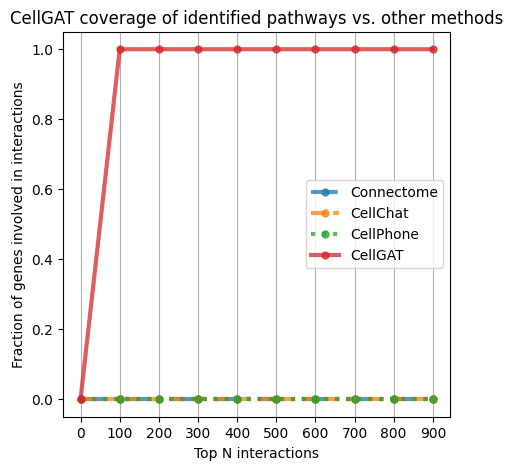

In [21]:
%matplotlib inline
plt.figure(figsize=(5,5))
line_styles = ["-.",'--',":"]*4
methods_list = ["Connectome","CellChat","CellPhone"]
for i in range(len(benchmarking_list)):
    plt.plot(range(0,1000,100),benchmarking_list[i],markersize=5,marker="o",linestyle=line_styles[i],label=methods_list[i],linewidth=3,alpha=0.75)
plt.plot(range(0,1000,100),CellGATv2_list,markersize=5,marker="o",label="CellGAT",linewidth=3,alpha=0.75)

plt.xticks(range(0,1000,100))
plt.grid(axis = 'x')
plt.title("CellGAT coverage of identified pathways vs. other methods")
plt.xlabel("Top N interactions")
plt.ylabel("Fraction of genes involved in interactions")
plt.legend()